Importing The Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import numpy as np
import datetime
import math
import statsmodels.api as sm
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras import callbacks
import matplotlib.pyplot as plt 

Importing The Dataset

In [2]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Jjxjx4PP2cinP9148Xz3sC3R0tNiNSkQCZB1hYRg5Fpm',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'oilpricepredictionmodel-donotdelete-pr-ysi4bytr8jpsf3'
object_key = 'CrudeOilPrices.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,Date,Price
0,"May 20, 1987",18.63
1,"May 21, 1987",18.45
2,"May 22, 1987",18.55
3,"May 25, 1987",18.60
4,"May 26, 1987",18.63


Handling Missing Data

In [3]:
df.isnull().sum()

Date     0
Price    8
dtype: int64

In [4]:
df['Price']=df['Price'].fillna(method='ffill')

In [5]:
df.isnull().sum()

Date     0
Price    0
dtype: int64

Data Visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


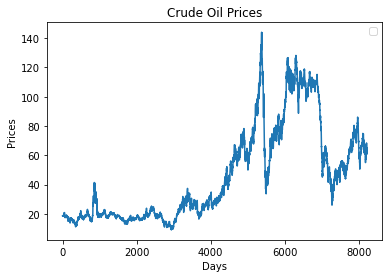

In [6]:
df_plot = df.iloc[:,1:2].values
plt.plot(df_plot)
plt.title('Crude Oil Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

Creating a dataset with sliding window

In [7]:
train_size=0.8
batch_size=32
train_len=len(df)*train_size
train_set_lengths=[]
for x in range(int(train_len-200),int(train_len)): 
  if(x%batch_size==0):
    train_set_lengths.append(x)
train_set_length=max(train_set_lengths)
train_set_length

6560

In [8]:
timesteps=30
train_1=train_set_length+timesteps*2
train_data_1= df[0:train_1]
training_set=train_data_1.iloc[:,1:2].values
training_set.shape

(6620, 1)

Feature Scaling

In [9]:
minmaxscaler = MinMaxScaler()
scaled_training_set=minmaxscaler.fit_transform(np.float64(training_set))
scaled_training_set

array([[0.07067112],
       [0.0693363 ],
       [0.07007786],
       ...,
       [0.69425287],
       [0.67675195],
       [0.67259918]])

Splitting Data Into Train And Test

In [10]:
X_train=[]
Y_train=[]
for i in range(timesteps, train_set_length+ timesteps): 
    X_train.append(scaled_training_set[i-timesteps:i,0])
    Y_train.append(scaled_training_set[i:i+timesteps,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))

Initializing The Model, Adding LSTM Layers, Adding Output Layers

In [11]:
input_layer=Input(batch_shape=(batch_size,timesteps,1))
lstm_layer_1=LSTM(8,stateful=True,return_sequences=True)(input_layer)
lstm_layer_2=LSTM(8,stateful=True,return_sequences=True)(lstm_layer_1)
output_layer=Dense(units=1)(lstm_layer_2)
regressor=Model(inputs=input_layer, outputs = output_layer)
regressor.compile(optimizer='adam',loss='mean_squared_error')

Train The Model

In [28]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss",mode="min",patience=5,restore_best_weights=True)
regressor.fit(X_train,Y_train,epochs=25,batch_size=batch_size,callbacks=[earlystopping])

Epoch 1/25
205/205 [==============================] - 2s 11ms/step - loss: 0.0020
Epoch 2/25
205/205 [==============================] - 2s 10ms/step - loss: 0.0020
Epoch 3/25
205/205 [==============================] - 2s 12ms/step - loss: 0.0020
Epoch 4/25
205/205 [==============================] - 2s 11ms/step - loss: 0.0020
Epoch 5/25
205/205 [==============================] - 2s 10ms/step - loss: 0.0020
Epoch 6/25
205/205 [==============================] - 2s 10ms/step - loss: 0.0020
Epoch 7/25
205/205 [==============================] - 3s 13ms/step - loss: 0.0020
Epoch 8/25
205/205 [==============================] - 2s 11ms/step - loss: 0.0020
Epoch 18/25
205/205 [==============================] - 2s 10ms/step - loss: 0.0019
Epoch 19/25
205/205 [==============================] - 2s 11ms/step - loss: 0.0020
Epoch 20/25
205/205 [==============================] - 2s 10ms/step - loss: 0.0019
Epoch 21/25
205/205 [==============================] - 2s 9ms/step - loss: 0.0019
Epoch 22/25
2

Save The Model

In [29]:
from tensorflow.keras.models import load_model
regressor.save("regressor.h5")
!tar -zcvf crudeoils.tgz regressor.h5

regressor.h5


Testing The Model

In [30]:
test_length_values=[]
for x in range(len(df)-200,len(df)-timesteps*2): 
  if ((x-train_1)%batch_size==0):
    test_length_values.append(x)
test_set_length=(max(test_length_values))
test_1 = test_set_length + timesteps*2
test_set_len = test_set_length-train_1
test_set_len

1504

In [31]:
df_data_1_test=df[train_1:test_1] 
test_set = df_data_1_test.iloc[:,1:2].values
scaled_test_set=minmaxscaler.fit_transform(np.float64(test_set))
X_test=[]
for i in range(timesteps,test_set_len+timesteps):
    X_test.append(scaled_test_set[i-timesteps:i, 0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
Y_pred=regressor.predict(X_test)
regressor.reset_states()
Y_pred= np.reshape(Y_pred,(Y_pred.shape[0],Y_pred.shape[1]))
Y_pred=minmaxscaler.inverse_transform(Y_pred)

(1504, 30, 1)


In [32]:
Y_pred_final=[]
for j in range(0,test_set_len-timesteps):
    Y_pred_final=np.append(Y_pred_final,Y_pred[j,timesteps-1])
Y_pred_final=np.reshape(Y_pred_final,(Y_pred_final.shape[0], 1))

Model Evaluation

In [33]:
print("Mean Squared Error: "+str(math.sqrt(mean_squared_error(test_set[timesteps:len(Y_pred_final)],Y_pred_final[0:len(Y_pred_final) - timesteps]))))
print("Mean Absolute Error: "+str(math.sqrt(mean_absolute_error(test_set[timesteps:len(Y_pred_final)],Y_pred_final[0:len(Y_pred_final) - timesteps]))))

Mean Squared Error: 6.100077414703862
Mean Absolute Error: 1.8724788971517141


In [18]:
!pip install watson-machine-learning-client

In [34]:
!pip install ibm_watson_machine_learning

In [35]:
from ibm_watson_machine_learning import APIClient
wml_credentials ={
    "url":"https://us-south.ml.cloud.ibm.com",
    "apikey":"2VGbFsZWkEhUNLxK0RfmxZ4WaIBaMOlTkwPyeKknduiO"
}
client = APIClient(wml_credentials)
client

In [36]:
def guid_space_name(client,B2_deploy):
  space = client.spaces.get_details()
  return(next(item for item in space['resources'] if item['entity']['name']==B2_deploy)['metadata']['id'])

In [37]:
space_uid = guid_space_name(client,'models')
space_uid

'6a53a29b-c382-4700-9b27-c637595dfe62'

In [38]:
client.set.default_space(space_uid)

'SUCCESS'

In [39]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [40]:
software_space_uid = client.software_specifications.get_uid_by_name('tensorflow_rt22.1-py3.9')
software_space_uid

'acd9c798-6974-5d2f-a657-ce06e986df4d'

In [41]:
model_details = client.repository.store_model(model='crudeoils.tgz',meta_props={
    client.repository.ModelMetaNames.NAME:"Crude_Oil_Price_Prediction",
    client.repository.ModelMetaNames.TYPE:"tensorflow_2.7",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_space_uid
})

In [42]:
model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'software_spec': {'id': 'acd9c798-6974-5d2f-a657-ce06e986df4d',
   'name': 'tensorflow_rt22.1-py3.9'},
  'type': 'tensorflow_2.7'},
 'metadata': {'created_at': '2022-11-17T16:48:56.481Z',
  'id': '0a372e8d-20b8-42ba-8fdd-b534b5cb7b9c',
  'modified_at': '2022-11-17T16:48:58.665Z',
  'name': 'Crude_Oil_Price_Prediction',
  'owner': 'IBMid-6620043JO4',
  'resource_key': 'd0265db6-e7da-44cb-a19d-ab7a25719d59',
  'space_id': '6a53a29b-c382-4700-9b27-c637595dfe62'},
 'system': {'warnings': []}}